# Intergrating Tri-OMICS

In [137]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import normalize
from mudata import MuData
import os.path as path
import seaborn as sns
import numexpr as ne
import pandas as pd
import scanpy as sc
import mudata as md
import numpy as np
import muon as mu
import anndata
import h5py
import time
import umap
import gc

## data introduction and prepocessing

In [49]:
adata_adt=sc.read_h5ad("adt_obj.h5ad")
adata_rna=sc.read_h5ad("rna_obj.h5ad")
adata_atac=sc.read_h5ad("atac_obj.h5ad")

In [54]:
adata_rna

AnnData object with n_obs × n_vars = 13763 × 15360
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'celltype', 'nCount_atac', 'nFeature_atac', 'nCount_adt', 'nFeature_adt'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [55]:
adata_atac

AnnData object with n_obs × n_vars = 13763 × 68963
    obs: 'orig.ident', 'nCount_atac', 'nFeature_atac', 'nCount_RNA', 'nFeature_RNA', 'stim', 'celltype', 'nCount_adt', 'nFeature_adt'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [56]:
adata_adt

AnnData object with n_obs × n_vars = 13763 × 210
    obs: 'orig.ident', 'nCount_adt', 'nFeature_adt', 'nCount_RNA', 'nFeature_RNA', 'stim', 'celltype', 'nCount_atac', 'nFeature_atac'
    var: 'features'

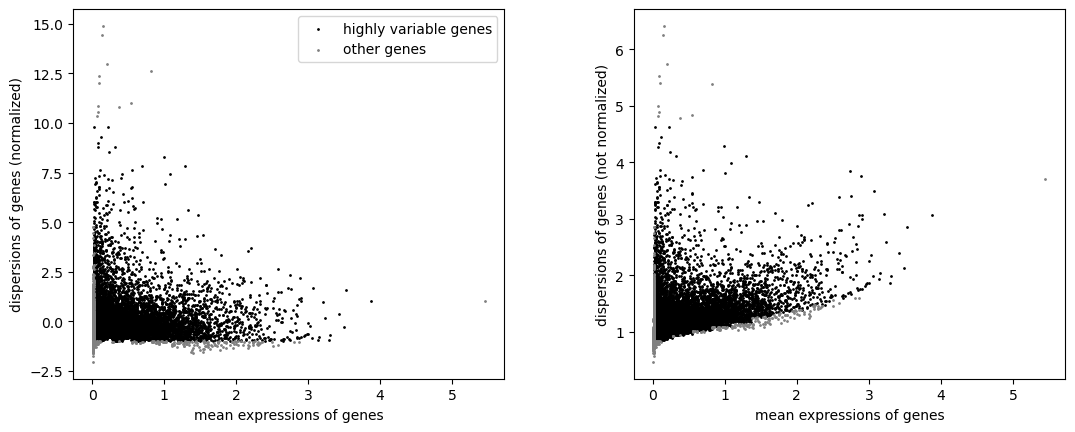

In [50]:
sc.pp.filter_genes(adata_rna, min_cells = 50)
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, min_mean=0.02, max_mean=4, min_disp= -1, max_disp = 10)
sc.pl.highly_variable_genes(adata_rna)

In [51]:
HVG = adata_rna[:, adata_rna.var['highly_variable'] == True]

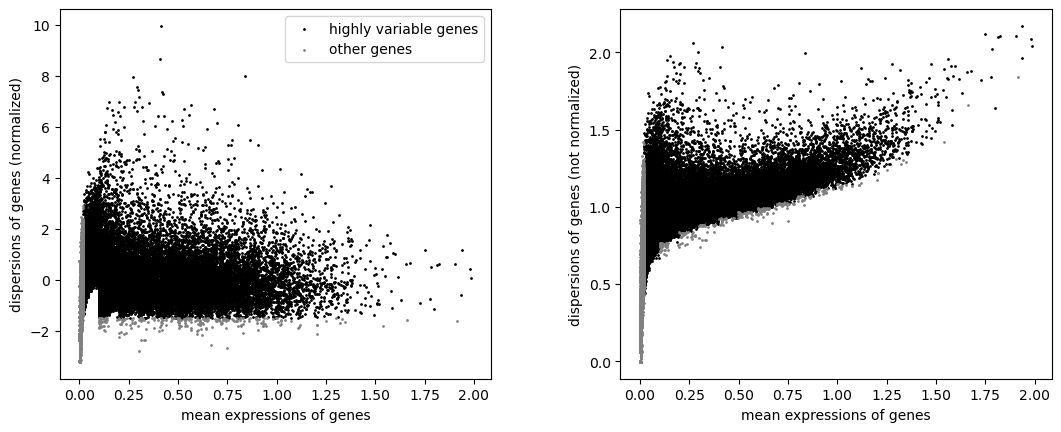

In [52]:
sc.pp.log1p(adata_atac)
sc.pp.highly_variable_genes(adata_atac, min_mean=0.02, max_mean=4, min_disp= -1.5, max_disp = 10)
sc.pl.highly_variable_genes(adata_atac)

In [53]:
HVP = adata_atac[:, adata_atac.var['highly_variable'] == True]

In [57]:
mdata = mu.MuData({'rna': HVG, 'atac': HVP, 'adt':adata_adt})

/home/data/ssy092/miniconda3/envs/maxine/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/data/ssy092/miniconda3/envs/maxine/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/data/ssy092/miniconda3/envs/maxine/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and p

In [59]:
 mdata.obs['celltype'] = adata_rna.obs['celltype'] 

In [60]:
 mdata

MuData object with n_obs × n_vars = 13763 × 65654
  obs:	'celltype'
  3 modalities
    rna:	13763 x 13002
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'celltype', 'nCount_atac', 'nFeature_atac', 'nCount_adt', 'nFeature_adt'
      var:	'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	13763 x 52442
      obs:	'orig.ident', 'nCount_atac', 'nFeature_atac', 'nCount_RNA', 'nFeature_RNA', 'stim', 'celltype', 'nCount_adt', 'nFeature_adt'
      var:	'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    adt:	13763 x 210
      obs:	'orig.ident', 'nCount_adt', 'nFeature_adt', 'nCount_RNA', 'nFeature_RNA', 'stim', 'celltype', 'nCount_atac', 'nFeature_atac'
      var:	'features'

## running TriTan

In [ ]:
import TriTan

In [115]:
n_component= {'rna': [20,50], 'atac': [20,50], 'adt': [20,50]}

In [116]:
tritan = TriTan_multi.TriTan(n_modalities = 3, n_component=n_component,complexity = 10)

In [117]:
tritan.fit(mdata)

/home/data1/ssy092/maxine_neurip/TriTan_multi.py:255: RuntimeWarning: invalid value encountered in divide
  # bound the values to -1 to 1 in the event of precision issues
/home/data1/ssy092/maxine_neurip/TriTan_multi.py:255: RuntimeWarning: invalid value encountered in divide
  # bound the values to -1 to 1 in the event of precision issues


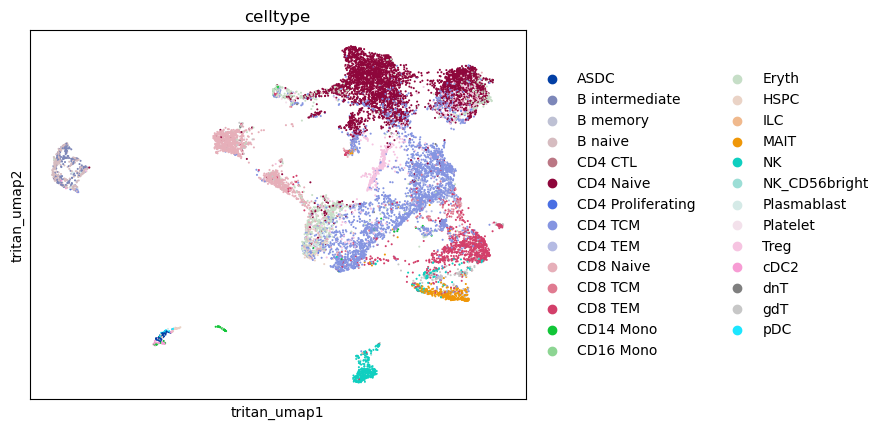

In [119]:
sc.pl.embedding(mdata, color ='celltype', basis='tritan_umap')

## downstream analysis

In [120]:
S_gene = tritan.S['rna']
S_atac = tritan.S['atac']
S_adt = tritan.S['adt']
S_gene = normalize(S_gene, axis=0, norm='max')
S_atac = normalize(S_atac, axis=0, norm='max')
S_adt = normalize(S_adt, axis=0, norm='max')

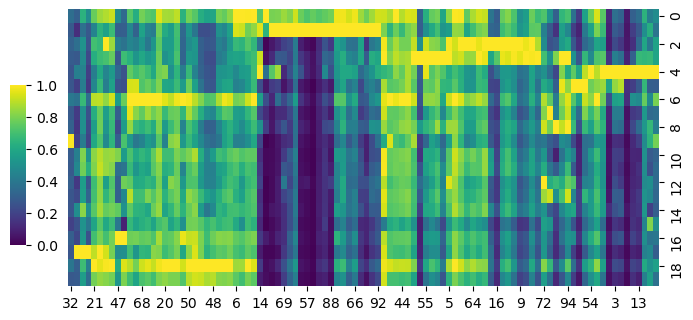

In [121]:
cg = sns.clustermap(S_gene,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

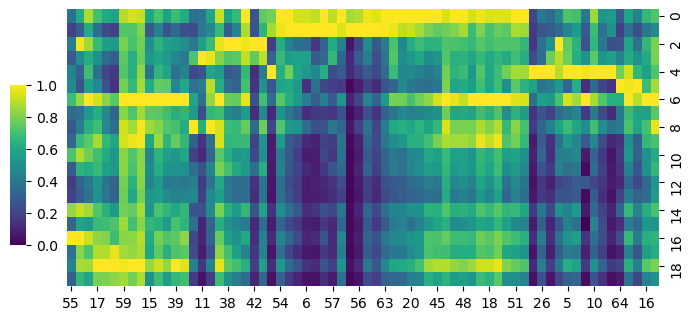

In [122]:
cg = sns.clustermap(S_atac,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

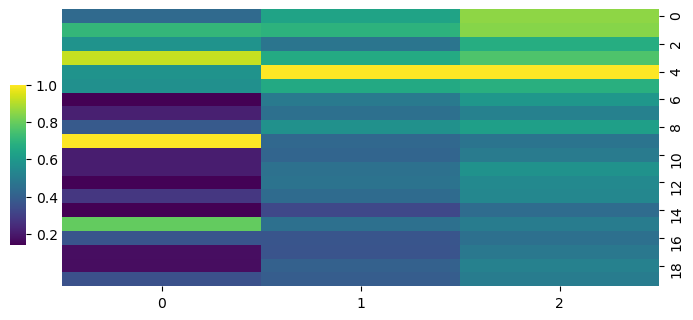

In [123]:
cg = sns.clustermap(S_adt,row_cluster=False,col_cluster=True,figsize=(8, 4), metric='correlation',cbar_pos=(0.14, .2, .02, .4),cmap='viridis')
cg.ax_row_dendrogram.set_visible(False) 
cg.ax_col_dendrogram.set_visible(False)

In [125]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)

In [126]:
I1 = np_pearson_cor(S_gene,S_atac)
I2 = np_pearson_cor(S_gene,S_adt)
I3 = np_pearson_cor(S_atac,S_adt)

Text(15, 1.5, 'rna&atac correlation matrix')

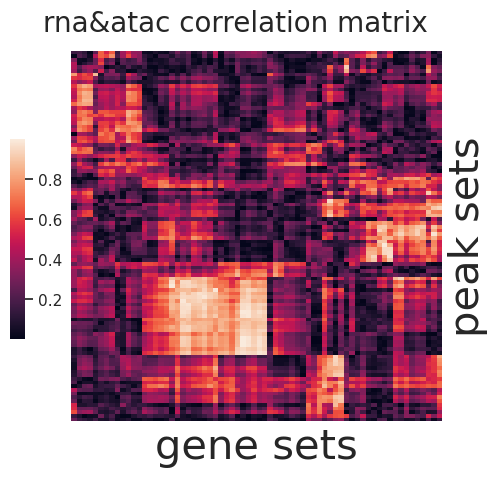

In [144]:
sns.set(font_scale=1)
g=sns.clustermap(np.abs(I1),figsize=(5, 5),
    cbar_pos=(0.1, .2, .03, .4), metric='correlation',yticklabels=False,xticklabels=False)
ax = g.ax_heatmap
g.ax_row_dendrogram.set_visible(False) 
g.ax_col_dendrogram.set_visible(False)
ax.set_xlabel('gene sets', fontsize=30)
ax.set_ylabel('peak sets', fontsize=30)
plt.title('rna&atac correlation matrix', fontsize=20,x=15,y=1.5)

Text(15, 1.5, 'rna&adt correlation matrix')

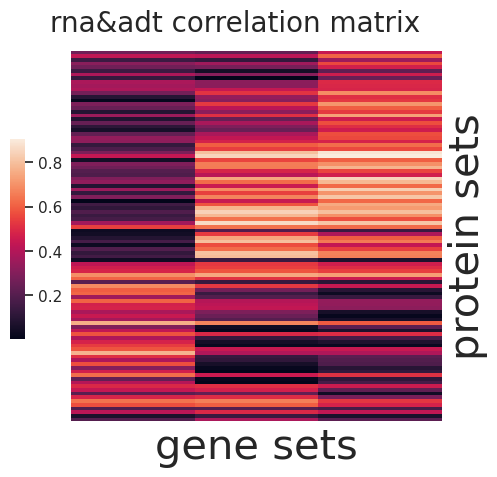

In [145]:
sns.set(font_scale=1)
g=sns.clustermap(np.abs(I2),figsize=(5, 5),
    cbar_pos=(0.1, .2, .03, .4), metric='correlation',yticklabels=False,xticklabels=False)
ax = g.ax_heatmap
g.ax_row_dendrogram.set_visible(False) 
g.ax_col_dendrogram.set_visible(False)
ax.set_xlabel('protein sets', fontsize=30)
ax.set_ylabel('gene sets', fontsize=30)
plt.title('rna&adt correlation matrix', fontsize=20,x=15,y=1.5)

Text(15, 1.5, 'atac&adt correlation matrix')

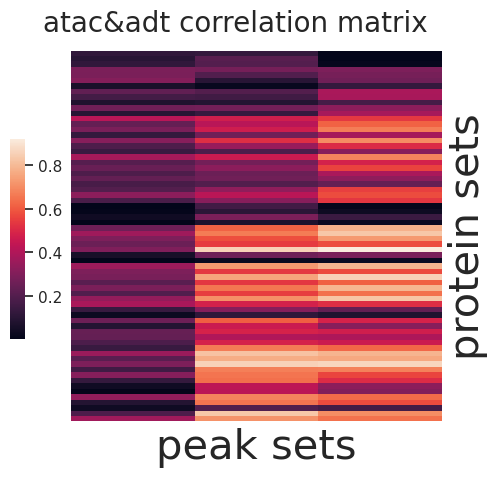

In [146]:
sns.set(font_scale=1)
g=sns.clustermap(np.abs(I3),figsize=(5, 5),
    cbar_pos=(0.1, .2, .03, .4), metric='correlation',yticklabels=False,xticklabels=False)
ax = g.ax_heatmap
g.ax_row_dendrogram.set_visible(False) 
g.ax_col_dendrogram.set_visible(False)
ax.set_xlabel('protein setspeak sets', fontsize=30)
ax.set_ylabel('', fontsize=30)
plt.title('atac&adt correlation matrix', fontsize=20,x=15,y=1.5)